In [ ]:
import gc
import warnings

warnings.filterwarnings('ignore')
from importlib import reload
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import dask
#import xrft
import ephem
import cmocean
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35471")
client

2022-02-23 13:25:49 DEBUG    Using selector: EpollSelector
2022-02-23 13:25:49 DEBUG    Using selector: EpollSelector


<Client: 'tcp://127.0.0.1:35471' processes=8 threads=40, memory=62.68 GiB>

In [ ]:
from dask.distributed import Client

client = Client("tcp://158.97.14.41:9999")
client

<Client: 'tcp://158.97.14.41:9999' processes=4 threads=160, memory=60.00 GiB>

In [ ]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [ ]:
#%reload_ext autoreload
%autoreload

#reload() solo funciona si el módulo ya fue cargado
import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.filtering
reload(spectral_analysis.filtering)
from spectral_analysis.filtering import kxky, f_range
import spectral_analysis.tools.utils_thesis
reload(spectral_analysis.tools.utils_thesis)
from spectral_analysis.common_vars.directories import DATA_FOLDER
#from spectral_analysis.tools.utils_thesis import igw_disp_rel, igw_bm_partition_k

from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

In [ ]:
def kxky_(dx,dy,shape):
    Ny,Nx = shape
    logging.info("kxky -- Nx: {}, Ny: {}".format(Nx,Ny))
    Lx = Nx*dx
    Ly = Ny*dy
    logging.info("kxky -- Lx: {}, Ly: {}".format(Lx,Ly))
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*da.arange(-N_kx,N_kx+1)
    Ky = delta_ky*da.arange(-N_ky,N_ky+1)
    return Kx,Ky


def f_range_(dt,Nt):
    T = Nt*dt
    logging.info("f_range -- Nt: {}, T: {}".format(Nt,T))
    delta_om = 1/T
    N_om = (Nt-1)/2
    return  delta_om*da.arange(-N_om,N_om+1)

In [ ]:
## Units:
## kh,H: km
## f,Nbv: cph

def igw_disp_rel(kh, max_mode=10, f_coriolis=None, Nbv=0.8594, H=4.0, log=True):
    if log:
        print("N={0:.3f}, H={1:.3f} - mode {2}".format(Nbv, H, max_mode))
    kh = (2*np.pi)*kh 	# Transform to rad/km
    khnp_2 = (max_mode*np.pi/(kh*H))**2

    return da.sqrt( (Nbv**2 + ((f_coriolis**2)*khnp_2))/(1+khnp_2) )


def igw10_bm_partition_k(kh, fmax=1/12.0, **disp_kwargs):
    igw10 = igw_disp_rel(kh, max_mode=10, **disp_kwargs)
    logging.debug("igw10 shape: {}".format(igw10.shape))

    return da.fmin(igw10, fmax)


def create_igw10_cutoff(shape, dx=2.0, dy=2.0, dt=1.0, **partition_args):
    Nx,Ny,Nt = shape
    om_ = f_range_(dt,Nt)
    kx_,ky_ = kxky_(dx, dy, (Nx,Ny))
    kx,ky,om = da.meshgrid(kx_, ky_, om_)
    #logging.debug("spectral shape: {}, {}, {} --> {}, {}, {}", kx_.shape, ky_.shape, om_.shape, kx.shape, ky.shape, om.shape)

    kh_sq = da.square(kx)+da.square(ky)
    kh = da.sqrt(kh_sq)

    return igw10_bm_partition_k(kh, **partition_args), kx, ky, om


def create_filter_igw10(shape, order=50, **partition_args):
    cutoff_igw10, kx, ky, om = create_igw10_cutoff(shape,  **partition_args)
    logging.debug("cutoff_igw10 shape: {}".format(cutoff_igw10.shape))
    with np.errstate(over='ignore'):
        filter_mask_plt = 1/( 1 + ( da.square(om)/(cutoff_igw10**2) )**order )
        return filter_mask_plt, kx, ky, om


In [ ]:
# TODO: multiplicar por Hanning

def fft_3d(var_txy, inverse=False):
    _v_fft = var_txy
    dim = len(var_txy.shape)
    for ax in range(dim):
        rechunks = {x:'auto' for x in range(dim) }
        rechunks[ax] = -1
        _v_fft = _v_fft.rechunk(rechunks)
        _v_fft = da.fft.fft(_v_fft, axis=ax) if not inverse else da.fft.ifft(_v_fft, axis=ax)
    return _v_fft

#@dask.delayed(pure=True)
def filter_fft_butterworth_k_omega(var_txy, filter_mask, dx=2.0, dy=2.0, dt_h=1, t_axis=-1):
    logging.info("kx-ky-omega BW filter -- variable shape: {} -- type: {}".format(var_txy.shape, type(var_txy)))
    arr_delayed_kwargs = {"shape": var_txy.shape, "dtype": np.dtype('f')}
    filter_mask = da.fft.ifftshift(filter_mask)
    
    logging.info("Calculating FFT... mask type: {}".format(type(filter_mask)))
    #var_fft = xrft.fft(var_txy)
    var_fft = fft_3d(var_txy)
    logging.info("Filtering...")
    var_lo = filter_mask*var_fft
    del filter_mask
    
    # Volvemos al espacio físico
    logging.info("Calculating inverse FFT and complement")
    #var_lo = xrft.ifft(var_lo)
    var_lo = fft_3d(var_lo, inverse=True)
    logging.info("Taking real part FFT: {}".format(type(var_lo)))
    var_lo = da.real(var_lo)   # Eliminamos la parte imaginaria, ya que es espuria
    
    return var_lo


In [58]:
## Calculates "real" date from simualtion hours, given a start date
startDt = datetime.datetime(2011,9,13,0,0,0,0,tzinfo=datetime.timezone.utc)

def simulationTime(hours):
    return startDt + datetime.timedelta(hours=hours)

def timeUtc(simHours):
    return ephem.Date(simulationTime(simHours))

## Process region+season

In [148]:
from spectral_analysis.common_vars.directories import DATA_FOLDER
from spectral_analysis.common_vars.regions import lats4id, timezone_regions

current = "Canarias"
rid = 750 #730 #771
season="ASO"
season_tag="Summer"

lat_deg = lats4id[rid]
tzone = timezone_regions[current]

# Reminder: Nbv_cph_ = f_cph*Rd*np.pi/H, Rd1 = id_data.Rd1
id_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id').loc[rid]
f_cph = id_data.f_cph
Nbv_cph = id_data.Nbv_cph_2 ## This is not squared, but a revised version
H = id_data.H/1000

# For RV/DIV normalization
f_cps = f_cph/3600.0
f_rps = 2*np.pi*f_cps
f_rps_inv = 1.0/f_rps

750 0 ASO 26.641 0.0373670560546539 1.0379737792959417e-05 15333.233484939306 0.9788491670636053 4.902255868544601


In [ ]:
print(rid, tzone, season, lat_deg, f_cph, f_cps, f_rps, f_rps_inv, Nbv_cph, H)

In [149]:
gc.collect()
client.run(gc.collect)

{'tcp://158.97.14.41:35245': 817,
 'tcp://158.97.14.41:42197': 860,
 'tcp://158.97.14.41:44331': 548,
 'tcp://158.97.14.41:44339': 508}

In [150]:
timevec = idx_t["hours"][season]

region = LLCRegion(rid, timevec, tag=season_tag, nWorkers=40)
grid = region.getGrid()
XG,YG = region.getGridG()
region.loadScalar("U")
region.loadScalar("V")
UU = region.get("U")
VV = region.get("V")

2022-02-24 00:38:27 INFO     Grid: dx = 2.0694956027777773 km, dy = 1.902540301736111 km, dt = 1 h
2022-02-24 00:38:27 INFO     Exists? 750: _Summer -- Filename /mnt/Datos4TB/antonio/Tesis/LLC4230/Postprocess/wk_spectra/750_Summer_hours.npz
2022-02-24 00:38:27 INFO     Spectra - Variables: []
2022-02-24 00:38:27 INFO     Loading U: shape (k=0): (288, 289, 2208)
2022-02-24 00:38:27 INFO     Loading V: shape (k=0): (288, 289, 2208)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


In [159]:
ds_time = pd.date_range(simulationTime(timevec[0]), freq="H", periods=len(timevec))
ds_time

DatetimeIndex(['2012-08-01 00:00:00+00:00', '2012-08-01 01:00:00+00:00',
               '2012-08-01 02:00:00+00:00', '2012-08-01 03:00:00+00:00',
               '2012-08-01 04:00:00+00:00', '2012-08-01 05:00:00+00:00',
               '2012-08-01 06:00:00+00:00', '2012-08-01 07:00:00+00:00',
               '2012-08-01 08:00:00+00:00', '2012-08-01 09:00:00+00:00',
               ...
               '2012-10-31 14:00:00+00:00', '2012-10-31 15:00:00+00:00',
               '2012-10-31 16:00:00+00:00', '2012-10-31 17:00:00+00:00',
               '2012-10-31 18:00:00+00:00', '2012-10-31 19:00:00+00:00',
               '2012-10-31 20:00:00+00:00', '2012-10-31 21:00:00+00:00',
               '2012-10-31 22:00:00+00:00', '2012-10-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=2208, freq='H')

In [151]:
UU

dask.array<stack, shape=(288, 289, 2208), dtype=float32, chunksize=(288, 289, 1), chunktype=numpy.ndarray>

In [152]:
U_tmp = da.moveaxis(UU, -1, 0)
V_tmp = da.moveaxis(VV, -1, 0)
RV_ = grid.rv(U_tmp, V_tmp)*f_rps_inv
DIV_ = grid.div(U_tmp, V_tmp)*f_rps_inv
RV = da.moveaxis(RV_, 0, -1)
DIV = da.moveaxis(DIV_, 0, -1)

In [153]:
RV

dask.array<transpose, shape=(288, 289, 2208), dtype=float64, chunksize=(288, 289, 1), chunktype=numpy.ndarray>

In [160]:
ds = xr.Dataset(
    {
        "U": (["i", "j", "t"], UU),
        "V": (["i", "j", "t"], VV),
        "RV": (["i", "j", "t"], RV),
        "DIV": (["i", "j", "t"], DIV),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], ds_time),
    }
)

gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 288, j: 289, t: 2208)
Coordinates:
    lon      (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat      (i, j) float64 24.18 24.18 24.18 24.18 ... 29.09 29.09 29.09 29.09
    time     (t) object 1343779200000000000 ... 1351724400000000000
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 dask.array<chunksize=(288, 289, 1), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(288, 289, 1), meta=np.ndarray>
    RV       (i, j, t) float64 dask.array<chunksize=(288, 289, 1), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(288, 289, 1), meta=np.ndarray>

In [ ]:
ds.to_netcdf("{}/datasets/{}_{}.nc".format(DATA_FOLDER, rid, season))

In [ ]:
del UU,VV,RV,DIV
gc.collect()

#### Checkpoint 1

In [ ]:
ds = xr.open_dataset("{}/datasets/{}_{}.nc".format(DATA_FOLDER, rid, season), chunks='auto')
ds

In [27]:
filter_mask, *_ = create_filter_igw10(ds.U.shape, fmax=1.0/12.5, f_coriolis=f_cph, Nbv=Nbv_cph, H=H)

2022-02-23 19:10:42 INFO     f_range -- Nt: 2184, T: 2184.0
2022-02-23 19:10:42 INFO     kxky -- Nx: 289, Ny: 288
2022-02-23 19:10:42 INFO     kxky -- Lx: 578.0, Ly: 576.0
2022-02-23 19:10:42 DEBUG    igw10 shape: (288, 289, 2184)
2022-02-23 19:10:42 DEBUG    cutoff_igw10 shape: (288, 289, 2184)


N=0.979, H=4.902 - mode 10


In [28]:
U_lo = filter_fft_butterworth_k_omega(ds.U.data, filter_mask)
V_lo = filter_fft_butterworth_k_omega(ds.V.data, filter_mask)
U_hi = ds.U - U_lo
V_hi = ds.V - V_lo

2022-02-23 19:10:42 INFO     kx-ky-omega BW filter -- variable shape: (288, 289, 2184) -- type: <class 'dask.array.core.Array'>
2022-02-23 19:10:42 INFO     Calculating FFT... mask type: <class 'dask.array.core.Array'>
2022-02-23 19:10:42 INFO     Filtering...
2022-02-23 19:10:42 INFO     Calculating inverse FFT and complement
2022-02-23 19:10:42 INFO     Taking real part FFT: <class 'dask.array.core.Array'>
2022-02-23 19:10:42 INFO     kx-ky-omega BW filter -- variable shape: (288, 289, 2184) -- type: <class 'dask.array.core.Array'>
2022-02-23 19:10:42 INFO     Calculating FFT... mask type: <class 'dask.array.core.Array'>
2022-02-23 19:10:42 INFO     Filtering...
2022-02-23 19:10:42 INFO     Calculating inverse FFT and complement
2022-02-23 19:10:42 INFO     Taking real part FFT: <class 'dask.array.core.Array'>


In [29]:
ds["U_low"] = (["i", "j", "t"], U_lo)
ds["V_low"] = (["i", "j", "t"], V_lo)
ds["U_high"] = U_hi#(["i", "j", "t"], U_hi)
ds["V_high"] = V_hi#(["i", "j", "t"], V_hi)

In [30]:
ds.to_netcdf("{}/datasets/{}_{}2.nc".format(DATA_FOLDER, rid, season))
del U_lo, V_lo, U_hi, V_hi
gc.collect()

352

#### Checkpoint 2

In [31]:
ds = xr.open_dataset("{}/datasets/{}_{}2.nc".format(DATA_FOLDER, rid, season), chunks='auto')
ds

<xarray.Dataset>
Dimensions:  (i: 288, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2184,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    RV       (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    U_low    (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_low    (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    U_high   (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_high   (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>

In [32]:
U_lo = da.moveaxis(ds.U_low.data, -1, 0)
V_lo = da.moveaxis(ds.V_low.data, -1, 0)
U_hi = da.moveaxis(ds.U_high.data, -1, 0)
V_hi = da.moveaxis(ds.V_high.data, -1, 0)

RV_lo = grid.rv(U_lo, V_lo)*f_rps_inv
DIV_lo = grid.div(U_lo, V_lo)*f_rps_inv
RV_hi = grid.rv(U_hi, V_hi)*f_rps_inv
DIV_hi = grid.div(U_hi, V_hi)*f_rps_inv

## RV, DIV
ds["RVlo"] = (["i", "j", "t"], da.moveaxis(RV_lo, 0, -1))
ds["RVhi"] = (["i", "j", "t"], da.moveaxis(RV_hi, 0, -1))
ds["DIVlo"] = (["i", "j", "t"], da.moveaxis(DIV_lo, 0, -1))
ds["DIVhi"] = (["i", "j", "t"], da.moveaxis(DIV_hi, 0, -1))

In [33]:
ds.to_netcdf("{}/datasets/{}_{}3.nc".format(DATA_FOLDER, rid, season))
del RV_lo, DIV_lo, RV_hi, DIV_hi, U_lo, V_lo, U_hi, V_hi
gc.collect()

1914

In [36]:
season

'JFM'

#### Checkpoint 3

In [34]:
ds = xr.open_dataset("{}/datasets/{}_{}3.nc".format(DATA_FOLDER, rid, season), chunks='auto')
ds

<xarray.Dataset>
Dimensions:  (i: 288, j: 289, t: 2184)
Coordinates:
    lon      (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat      (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time     (t) int64 dask.array<chunksize=(2184,), meta=np.ndarray>
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    RV       (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIV      (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    U_low    (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_low    (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    U_high   (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_high   (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    RVlo     (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    RVhi     (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIVlo    (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIVhi    (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>

In [121]:
_tvec = [simulationTime(int(_t)+tzone) for _t in ds.time.values]
ds.drop_vars("time")
ds["time"] = (["t"], _tvec)
ds

<xarray.Dataset>
Dimensions:    (i: 288, j: 289, t: 2184)
Coordinates:
    lon        (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    lat        (i, j) float64 dask.array<chunksize=(288, 289), meta=np.ndarray>
    time       (t) object 2012-01-01T00:00:00+00:00 ... 2012-03-31T23:00:00+0...
Dimensions without coordinates: i, j, t
Data variables: (12/18)
    U          (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    V          (i, j, t) float32 dask.array<chunksize=(144, 211, 1092), meta=np.ndarray>
    RV         (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    DIV        (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    U_low      (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    V_low      (i, j, t) float64 dask.array<chunksize=(96, 238, 728), meta=np.ndarray>
    ...         ...
    RV_rms     (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    DIV_rms    (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    RVlo_rms   (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    DIVlo_rms  (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    RVhi_rms   (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>
    DIVhi_rms  (t) float64 dask.array<chunksize=(728,), meta=np.ndarray>

2022-02-24 00:31:14 DEBUG    Assigning font /b'F1' = '/home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-02-24 00:32:23 DEBUG    Embedding font /home/antonio/anaconda3/envs/thesis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-02-24 00:32:23 DEBUG    Writing TrueType font.


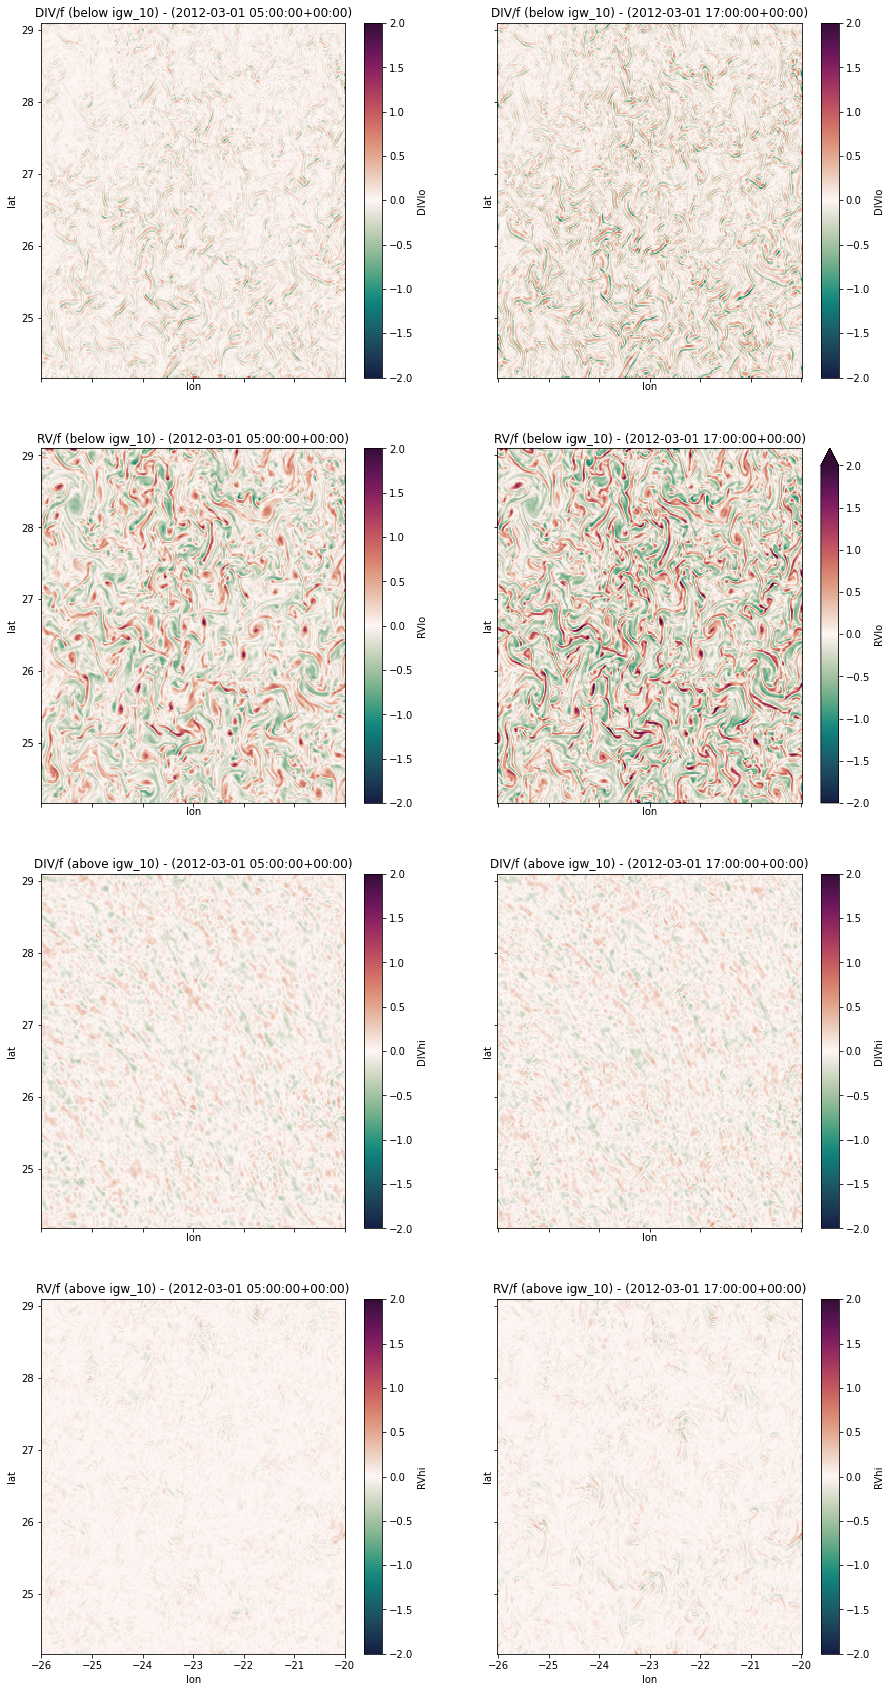

In [136]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-2, 'vmax':2}

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(15,30), sharex=True, sharey=True)
t_idx = 24*60+5

_ds1 = ds.isel(t=t_idx)
_t1 = _ds1.time.values.item()
_ds1.DIVlo.plot.pcolormesh(ax=ax[0,0], **fig_kwargs)
ax[0,0].set_title('DIV/f (below igw_10) - ({})'.format(_t1))
_ds1.RVlo.plot.pcolormesh(ax=ax[1,0], **fig_kwargs)
ax[1,0].set_title('RV/f (below igw_10) - ({})'.format(_t1))
_ds1.DIVhi.plot.pcolormesh(ax=ax[2,0], **fig_kwargs)
ax[2,0].set_title('DIV/f (above igw_10) - ({})'.format(_t1))
_ds1.RVhi.plot.pcolormesh(ax=ax[3,0], **fig_kwargs)
ax[3,0].set_title('RV/f (above igw_10) - ({})'.format(_t1))

_ds2 = ds.isel(t=t_idx+12)
_t2 = _ds2.time.values.item()
_ds2.DIVlo.plot.pcolormesh(ax=ax[0,1], **fig_kwargs)
ax[0,1].set_title('DIV/f (below igw_10) - ({})'.format(_t2))
_ds2.RVlo.plot.pcolormesh(ax=ax[1,1], **fig_kwargs)
ax[1,1].set_title('RV/f (below igw_10) - ({})'.format(_t2))
_ds2.DIVhi.plot.pcolormesh(ax=ax[2,1], **fig_kwargs)
ax[2,1].set_title('DIV/f (above igw_10) - ({})'.format(_t2))
_ds2.RVhi.plot.pcolormesh(ax=ax[3,1], **fig_kwargs)
ax[3,1].set_title('RV/f (above igw_10) - ({})'.format(_t2))

plt.savefig('figs/{}/RV-DIV_{}_am-pm.pdf'.format(rid, season))

plt.show()

### Calculate stats

In [137]:
ds["RV_rms"] = ds.RV.std(dim=("i","j"))
ds["DIV_rms"] = ds.DIV.std(dim=("i","j"))
ds["RVlo_rms"] = ds.RVlo.std(dim=("i","j"))
ds["DIVlo_rms"] = ds.DIVlo.std(dim=("i","j"))
ds["RVhi_rms"] = ds.RVhi.std(dim=("i","j"))
ds["DIVhi_rms"] = ds.DIVhi.std(dim=("i","j"))

### Plots: STDEV

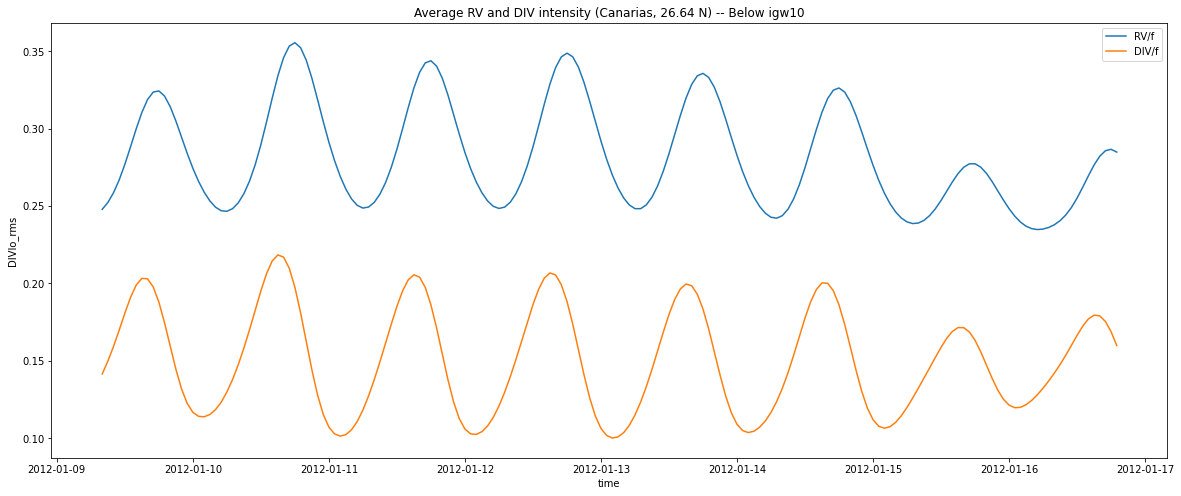

In [144]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.isel(t=slice(200,380)).plot(label="RV/f", x="time")
ds.DIVlo_rms.isel(t=slice(200,380)).plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current,lat_deg))
plt.savefig('figs/{}/RV-DIV_stdev_7days.png'.format(rid))
plt.show()

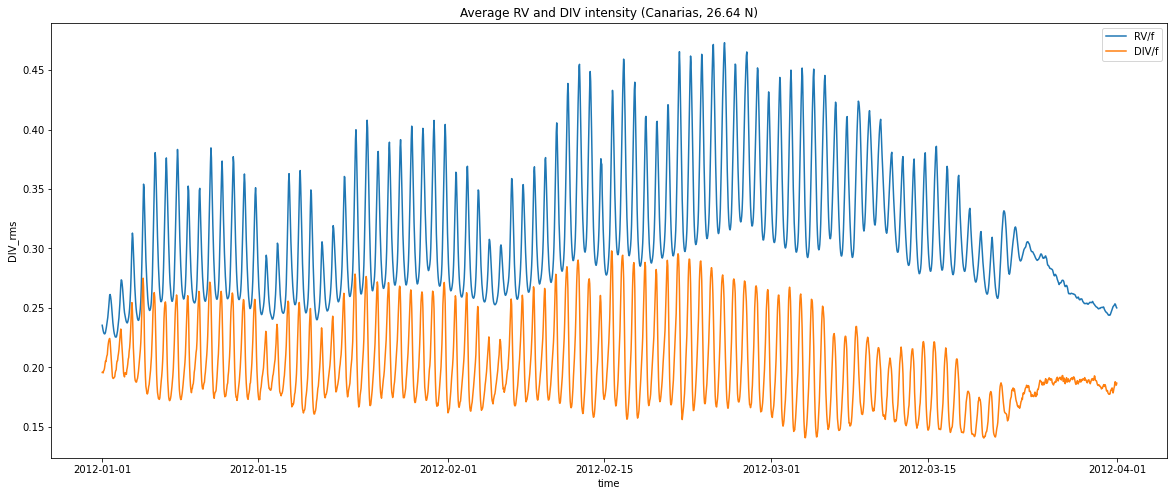

In [145]:
plt.figure(figsize=(20,8))
ds.RV_rms.plot(label="RV/f", x="time")
ds.DIV_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N)".format(current, lat_deg))
plt.savefig('figs/{}/RV-DIV_stdev.png'.format(rid))
plt.show()

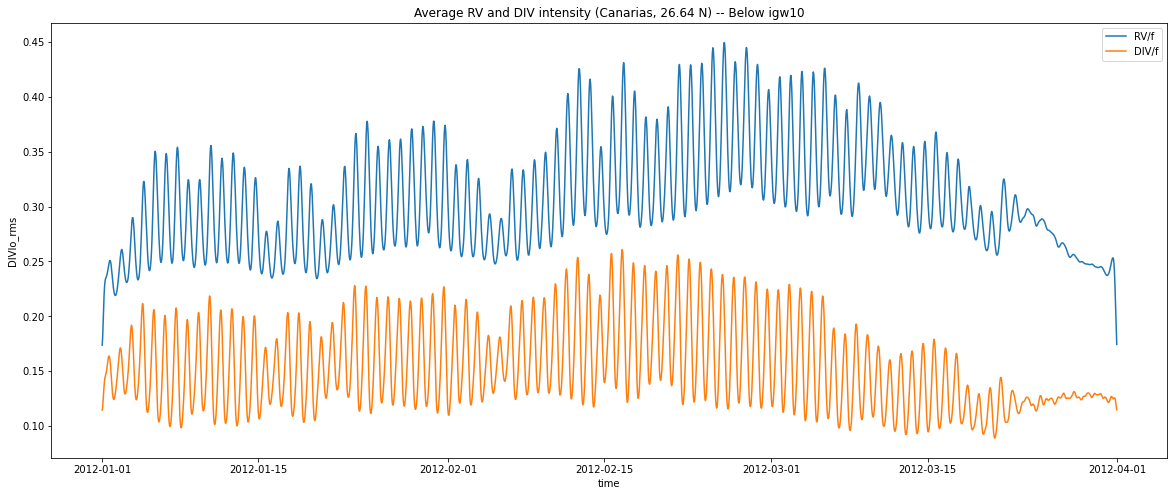

In [146]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.plot(label="RV/f", x="time")
ds.DIVlo_rms.plot(label="DIV/f", x="time")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Below igw10".format(current, lat_deg))
plt.savefig('figs/{}/RV-DIV_stdev_no-igw.png'.format(rid))
plt.show()

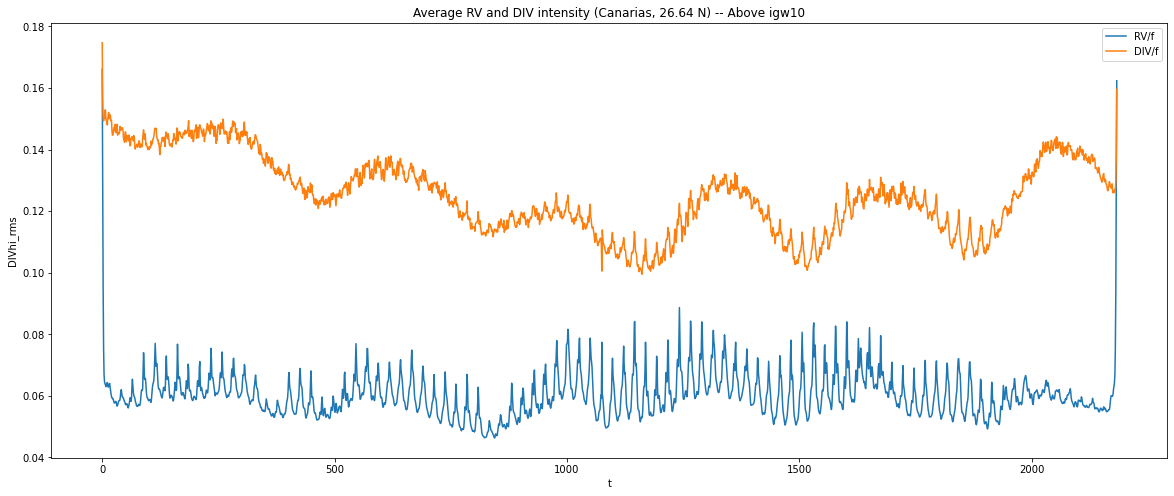

In [147]:
plt.figure(figsize=(20,8))
ds.RVhi_rms.plot(label="RV/f")
ds.DIVhi_rms.plot(label="DIV/f")
plt.legend()
plt.title("Average RV and DIV intensity ({}, {:0.2f} N) -- Above igw10".format(current, lat_deg))
plt.savefig('figs/{}/RV-DIV_stdev_only-igw.png'.format(rid))
plt.show()